# Assortative Betweenness of Graphs with Discrete Node Labels
## By Moses Boudourides & Mitali Kessinger

In [1]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import random
import math
import operator
import numpy as np
import itertools as it
# import community as louvain
import networkx.algorithms.community as nx_comm
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
# from networkx.drawing.nx_agraph import pygraphviz_layout
from networkx.drawing.nx_agraph import to_agraph
#from IPython.core.display import Image, display
from itertools import combinations, permutations, product

In [2]:
def weight_attr(G,maxw):
    # G is a graph
    # maxw is a positive integer (maximum weight value)
    weight={}
    for edge in G.edges():
        ed=edge[0]
        de=edge[1]
        G[ed][de]['weight']=random.randrange(1,maxw)
        weight[(ed,de)]=G[ed][de]['weight']
    return weight

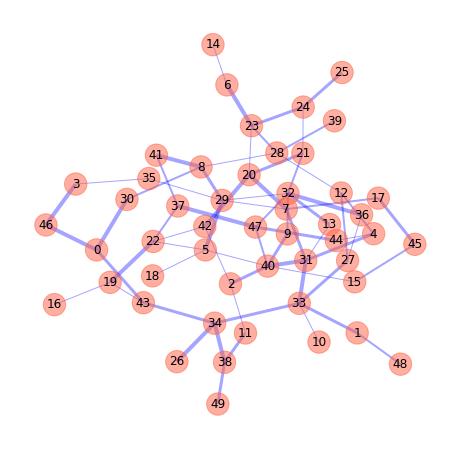

In [3]:
cmap=plt.cm.tab20  # plt.cm.Set1 # plt.cm.tab10 

name = "Erdos-Renyi random"

while True:
    G = nx.erdos_renyi_graph(n=50, p=0.05) #, directed=True) #n=100, p=0.03
    if len(list(nx.isolates(G)))<1:
        if nx.is_directed(G) == False:
            if nx.is_connected(G):
                break    
        else:
            if nx.is_weakly_connected(G):
                break

# while True:
#     G = nx.erdos_renyi_graph(n=100, p=0.02) #, directed=True)
#     if nx.is_directed(G):
#         if nx.is_weakly_connected(G):
#             break
#     else:
#         if nx.is_connected(G): 
#             break

# G=nx.karate_club_graph()

maxw=5 #random.randint(3,11) #(5,16)
weight=weight_attr(G,maxw)
w_edges=[(x,y,z) for (x,y),z in weight.items()]
G.add_weighted_edges_from(w_edges)

edge_width=[G[u][v]['weight'] for u,v in G.edges()] 
edge_width=[w for w in edge_width]

sizes=[500 for n in G.nodes()]

pos=graphviz_layout(G)
plt.figure(figsize=(8,8));

nodes = nx.draw_networkx_nodes(G, pos,node_size=sizes, node_color="tomato", alpha=0.3)
nx.draw_networkx_edges(G, pos,arrowsize=20, width=edge_width, edge_color="b", alpha=0.35)
nx.draw_networkx_labels(G, pos)

nodes = nx.draw_networkx_nodes(G, pos,node_size=sizes, node_color="tomato", alpha=0.3)

plt.axis('off');

In [4]:
def re_pos(pos,centre,radius):
    plist=[list(v) for v in pos.values()]
    nplist=[v for v in pos.values()]
    x = [p[0] for p in plist]
    y = [p[1] for p in plist]
    centroid = (sum(x) / float(len(plist)), sum(y) / float(len(plist)))
    ncentroid=np.array(centroid)
    rad=max([np.linalg.norm(nplist[i]-ncentroid) for i in range(len(nplist))])
    rpos={}
    for k,v in pos.items():
        rpos[k]=[(v[0]+centre[0])/float(radius),(v[1]+centre[1])/float(radius)]
    return rpos

In [5]:
def equipartic(G,k):
    # G is a graph
    # k is an integer > 1
    nodes=list(G.nodes())
    random.shuffle(nodes)
    S=[sorted(x) for x in np.array_split(nodes, k)]
    pattr={}
    for n in G.nodes():
        for i,s in enumerate(S):
            if n in s:
                pattr[n]=i
    return S, pattr

In [6]:
def b_c(G,S):
    B=[]
    C=[]
    GS=G.subgraph(S)
    for n in GS.nodes():
        if len([m for m in list(G.neighbors(n)) if m not in GS.nodes()])>0:
            B.append(n) 
        else:
            C.append(n)
    return sorted(B), sorted(C)

In [7]:
def two_cycles(G,b,c,compr):
    Gb=G.subgraph(b)
    Gc=G.subgraph(c)
    posb=nx.circular_layout(Gb)
    posc=nx.circular_layout(Gc)
    for n in Gc:
        posc[n]=[compr*posc[n][0],compr*posc[n][1]]
    for n in Gb:
        if len(Gb.nodes()) == 1:
            posb[n]=[2*compr, 2*compr]
    posbc={}
    for n in G.nodes():
        if n in b:
            posbc[n]=posb[n]
        else:
            posbc[n]=posc[n]
    return posbc

In [8]:
def shifted_pos_creator(G, partition, kk, Mag, Rad, compr):
    S={}
    for i in range(kk):
        s=[]
        for k,v in partition.items():
            if v==i:
                s.append(k)
        S[i]=s

    pos=nx.circular_layout(nx.cycle_graph(len(S))) #cmms

    circpos=[]
    for k,v in S.items():
        Gi=G.subgraph(v) 
        
        b,c=b_c(G,Gi.nodes())
        posi=two_cycles(Gi,b,c,compr)
#         posi=nx.circular_layout(Gi)
        
        circpos.append(posi)
    centers=list(pos.values())

    centerm=[]
    for i in range(len(centers)):
        t=[]
        for j in centers[i]:
            t.append(j*Mag) 
        centerm.append(np.array(t))
    centers=centerm

    poslist=[]
    for c,d in enumerate(circpos):
        pi=circpos[c] #i
        ci=centers[c] #i
        posii=re_pos(pi,ci,Rad)
        poslist.append(posii)

    P1=[]
    for p in poslist:
        P1+=list(p.items())
    P2=set()
    for p in poslist:
        P2&=set(p)
    P3={}
    Q=[]
    for k in P2:
        for p in poslist:
            P3+=p
        Q.append((k,P3)) 
    posAll=dict(P1+Q)
    
    return posAll

### Random Equipartitions

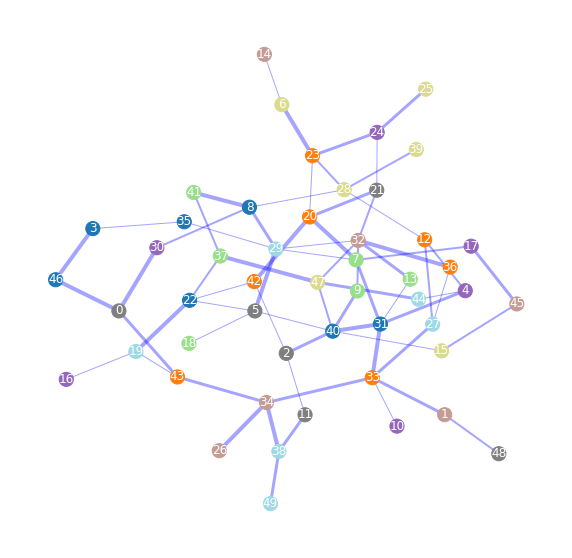

In [9]:
k=8
partition=equipartic(G,k)[1]

plt.figure(figsize=(10,10));

sizes1=[200 for n in G.nodes()]
pos=graphviz_layout(G)

nodes = nx.draw_networkx_nodes(G, pos,node_size=sizes1, node_color=list(partition.values()),cmap=cmap) #Blues)
nx.draw_networkx_edges(G, pos,arrowsize=20, width=edge_width, edge_color="b", alpha=0.35)
nx.draw_networkx_labels(G, pos, font_color='white')
plt.axis('off');

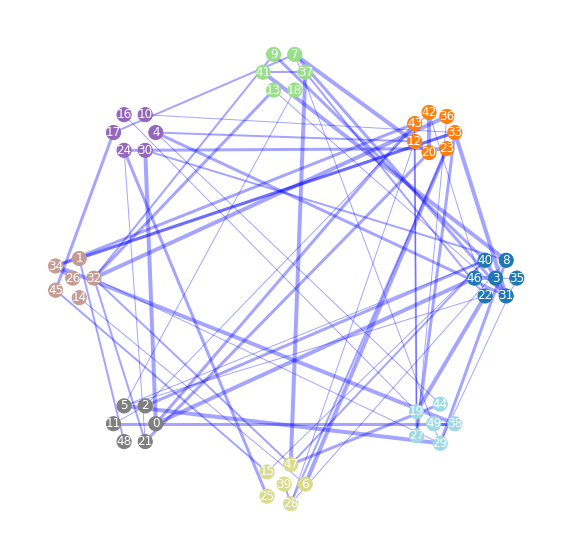

In [10]:
Mag=10
Rad=1
compr=0.3
posAll=shifted_pos_creator(G, partition, k, Mag, Rad, compr)

plt.figure(figsize=(10,10));

sizes1=[200 for n in G.nodes()]
pos=posAll

nodes = nx.draw_networkx_nodes(G, pos,node_size=sizes1, node_color=list(partition.values()),cmap=cmap) #Blues)
nx.draw_networkx_edges(G, pos,arrowsize=20, width=edge_width, edge_color="b", alpha=0.35)
nx.draw_networkx_labels(G, pos, font_color='white')
plt.axis('off');

### Partitions into Louvain Communities

8 Louvain commumities


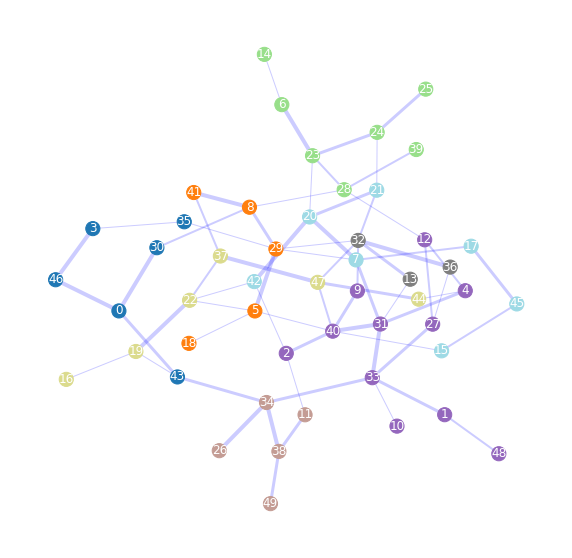

In [11]:
partition_l=nx_comm.louvain_communities(G, seed=123) #louvain.best_partition(G)
kk=len(partition_l)
partition={}
for n in G.nodes():
    for i,j in enumerate(partition_l):
        if n in j:
            partition[n]=i
            
# kk=len(set(partition.values()))
print("%i Louvain commumities" %kk)

plt.figure(figsize=(10,10));

sizes1=[200 for n in G.nodes()]
pos=graphviz_layout(G)

nodes = nx.draw_networkx_nodes(G, pos,node_size=sizes1, node_color=list(partition.values()),cmap=cmap) #Blues)
nx.draw_networkx_edges(G, pos,arrowsize=20, width=edge_width, edge_color="b", alpha=0.2)
nx.draw_networkx_labels(G, pos, font_color='white')
plt.axis('off');

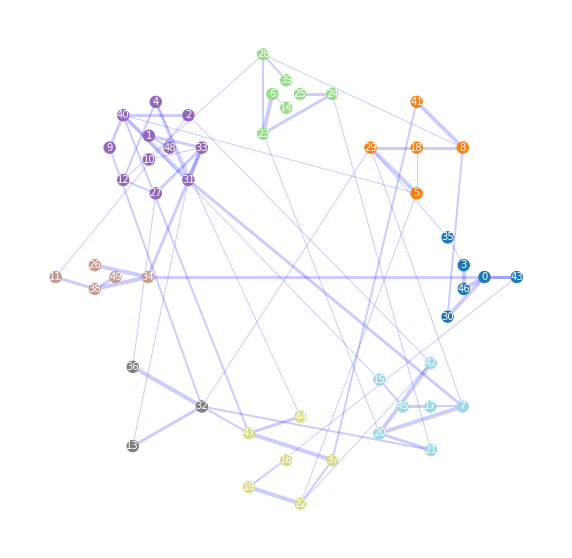

In [12]:
Mag=4  #5
Rad=1
compr=0.3
posAll=shifted_pos_creator(G, partition, kk, Mag, Rad, compr)

plt.figure(figsize=(10,10));

sizes1=[130 for n in G.nodes()]
pos=posAll

nodes = nx.draw_networkx_nodes(G, pos,node_size=sizes1, node_color=list(partition.values()),cmap=cmap) #Blues)
nx.draw_networkx_edges(G, pos,arrowsize=20, width=edge_width, edge_color="b", alpha=0.2)
nx.draw_networkx_labels(G, pos, font_color='white',font_size=10)
plt.axis('off');

### The Graph of Aggregated Communities (Cores and Boundaries)

In [13]:
allcomms_boundaries=[]
for i in range(kk):
    if i<9:
        allcomms_boundaries.append("Bc0"+str(i+1))  
    else:
        allcomms_boundaries.append("Bc"+str(i+1))
allcomms_cores=[]
for i in range(kk):
    if i<9:
        allcomms_cores.append("Cc0"+str(i+1))  
    else:
        allcomms_cores.append("Cc"+str(i+1))

In [14]:
edges_in_cores=[]
for com in allcomms_cores:
    i=int(com[2:])-1
    core=b_c(G,[list(x) for x in partition_l][i])[1] 
    if len(core)>0:
        W=0
        for e in G.edges(data=True):  
            if e[0] in core and e[1] in core:
                W+=e[2]['weight']
        if W!=0:
            edges_in_cores.append((com,com,W))
# edges_in_cores

edges_in_boundaries=[]
for com in allcomms_boundaries:
    i=int(com[2:])-1
    boundary=b_c(G,[list(x) for x in partition_l][i])[0] 
    if len(boundary)>0:
        W=0
        for e in G.edges(data=True):
            if e[0] in boundary and e[1] in boundary:
                W+=e[2]['weight']
        if W!=0:
            edges_in_boundaries.append((com,com,W))
# edges_in_boundaries

edges_among_cores_boundaries=[]
for j in list(zip(allcomms_cores,allcomms_boundaries)): 
    i=int(j[0][2:])-1
    core=b_c(G,[list(x) for x in partition_l][i])[1]
    boundary=b_c(G,[list(x) for x in partition_l][i])[0] 
    if len(core)>0 and len(boundary)>0:
        W=0
        for e in G.edges(data=True):
            if (e[0] in core and e[1] in boundary) or (e[1] in core and e[0] in boundary): 
                W+=e[2]['weight']           
        if W!=0:
            edges_among_cores_boundaries.append((j[0],j[1],W))
# for j in list(zip(allcomms_boundaries,allcomms_cores)): 
#     i=int(j[0][2:])-1
#     boundary=b_c(G,[list(x) for x in partition_l][i])[0]
#     core=b_c(G,[list(x) for x in partition_l][i])[1] 
#     W=0
#     for e in G.edges(data=True):
#         if (e[0] in core and e[1] in boundary) or (e[1] in core and e[0] in boundary): 
#             W+=e[2]['weight']           
#     if W!=0:
#         edges_among_cores_boundaries.append((j[0],j[1],W))
# edges_among_cores_boundaries

edges_among_boundaries=[]
for j in [x for x in list(product(allcomms_boundaries, repeat=2)) if x[0]!=x[1]]:
    i1=int(j[0][2:])-1
    i2=int(j[1][2:])-1
    boundary1=b_c(G,[list(x) for x in partition_l][i1])[0]
    boundary2=b_c(G,[list(x) for x in partition_l][i2])[0]
    if len(boundary1)>0 and len(boundary2)>0:
        W=0
        for e in G.edges(data=True):
            if (e[0] in boundary1 and e[1] in boundary2) or (e[1] in boundary1 and e[0] in boundary2):
                W+=e[2]['weight']
        if W!=0:
            edges_among_boundaries.append((j[0],j[1],W))
edges_among_boundaries

weds=edges_in_cores+edges_in_boundaries+edges_among_cores_boundaries+edges_among_boundaries
print(len(weds))
AG=nx.Graph()
AG.add_weighted_edges_from(weds)
print(len(AG.nodes),len(AG.edges))
print(sum([e[2]['weight'] for e in G.edges(data=True)]),sum([e[2]['weight'] for e in AG.edges(data=True)]))

52
15 35
164 164


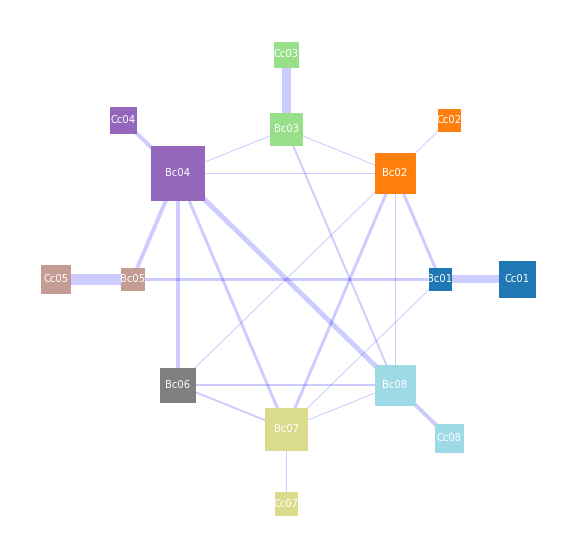

In [15]:
A=AG.copy()

dis=1.5 # 1.3

poscc={}
posc=nx.circular_layout(nx.cycle_graph(kk))
for n in A.nodes():
    if n in allcomms_boundaries:
        poscc[n]=posc[int(n.replace("Bc",""))-1]
    else:
        poscc[n]=dis*posc[int(n.replace("Cc",""))-1]  

# Aedge_width=[A[u][v]['weight'] for u,v in A.edges()] 
# Aedge_width=[w for w in Aedge_width]

sl={}
for n in A.nodes():
    W=0
    for e in A.edges(data=True):
        if e[0]==n and e[1]==n:
            W+=5+e[2]['weight']
    if W!=0:
        sl[n]=W
    else:
        sl[n]=5
sle=[e for e in A.edges() if e[0]==e[1]]
A.remove_edges_from(sle)

Aedge_width=[A[u][v]['weight'] for u,v in A.edges()] 
# Aedge_width=[w for w in Aedge_width]

plt.figure(figsize=(10,10));

sizes1=[100*sl[n] for n in A.nodes()]

my_colors_d={}
for n in A.nodes():
    i=int(n.replace("Bc","").replace("Cc",""))
    my_colors_d[n]=i
        
nodes = nx.draw_networkx_nodes(A, poscc,node_size=sizes1,node_shape="s", node_color=list(my_colors_d.values()),cmap=cmap)

nx.draw_networkx_edges(A, poscc,arrowsize=20, width=Aedge_width, edge_color="b", alpha=0.2)
nx.draw_networkx_labels(A, poscc, font_color='white',font_size=10)
plt.axis('off');

### Degree Participation Coefficient 
#### (for undirected graphs - needs slight modification for directed graphs)

In [16]:
nx.set_node_attributes(G, partition, "partition")

In [17]:
# for n in G.nodes(data=True):
#     print(n,n[0],n[1]['partition'])
# #     for m in list(G.neighbors(n[0])):
# #         print(pattr[n[0]],pattr[m])

In [18]:
part_neighs_d={}
for n in G.nodes(data=True):
    tt=[]
    for j in sorted(set(partition.values())):
        t=[]
        for m in list(G.neighbors(n[0])):
            if partition[m]==j:
                t.append(m)
        tt.append((j,len(t)))
    part_neighs_d[n[0]]=tt
# for k,v in part_neighs_d.items():
#     print(k,v)
# for k,v in part_neighs_d.items():
#     s=sum([x[1] for x in v])
#     print(k,G.degree(k),s)

In [19]:
degree_participation_coeff={}
for n in G.nodes():
    c=0
    for j in sorted(set(partition.values())):
        for k,v in part_neighs_d.items():
            if k==n:
                for vv in v:
                    if vv[0]==j:
                        c+=(vv[1]/G.degree(k))**2
#         print(n,j,c)
    degree_participation_coeff[n]=1-c
# for k,v in degree_participation_coeff.items():
#     print(k,v)

In [20]:
def comm_place(G,partition):
    d={}
    for n in G.nodes():
        x=partition[n]
        v=[m for m in G.nodes() if partition[m]==x]
        Gn=G.subgraph(v) 
        b,c=b_c(G,Gn.nodes())
        y=""
        if n in b:
            y+="boundary"
        else:
            y+="core"
        d[n]=(x,y)
    return d

In [21]:
partition=partition
# d=comm_place(G,partition)

dpc=[degree_participation_coeff[n] for n in G.nodes()]
com1=[comm_place(G,partition)[n][0] for n in G.nodes()]
com2=[comm_place(G,partition)[n][1] for n in G.nodes()]
bc=[nx.betweenness_centrality(G,weight="weight")[n] for n in G.nodes()]
lc=[nx.load_centrality(G,weight="weight")[n] for n in G.nodes()]
# clu=[nx.clustering(G,weight="weight")[n] for n in G.nodes()]

cdf=pd.DataFrame({
    "Node":G.nodes(),
    "Community":com1,
    "Type":com2,
    "Degree Participation Coefficient":dpc,
    "Betweenness Centrality":bc,
#     "Clustering":clu,
    "Load Centrality":lc
})
cdf

,Node,Community,Type,Degree Participation Coefficient,Betweenness Centrality,Load Centrality
0,0,0,core,0.000000,0.000000,0.000000
1,1,9,boundary,0.666667,0.032339,0.032502
2,2,7,core,0.000000,0.010194,0.010217
3,3,9,boundary,0.625000,0.026300,0.026554
4,4,8,boundary,0.625000,0.037623,0.037595
...,...,...,...,...,...,...
95,95,3,boundary,0.375000,0.030023,0.030245
96,96,1,boundary,0.625000,0.034471,0.034787
97,97,10,core,0.000000,0.016132,0.016491
98,98,9,boundary,0.666667,0.021082,0.021138


In [22]:
cdf[cdf["Degree Participation Coefficient"]==max(dpc)]

,Node,Community,Type,Degree Participation Coefficient,Betweenness Centrality,Load Centrality
7,7,1,boundary,0.8125,0.174789,0.174719


In [23]:
cdf_bound=cdf[(cdf["Type"]=="boundary")] #& (cdf["Degree Participation Coefficient"]==min(dpc))]
cdf_bound[cdf_bound["Degree Participation Coefficient"]==min(cdf_bound["Degree Participation Coefficient"])]

,Node,Community,Type,Degree Participation Coefficient,Betweenness Centrality,Load Centrality
87,87,5,boundary,0.277778,0.049141,0.048985


In [24]:
cdf[cdf.Node==60]

,Node,Community,Type,Degree Participation Coefficient,Betweenness Centrality,Load Centrality
60,60,8,boundary,0.444444,0.021563,0.021482


In [25]:
cdf[cdf["Betweenness Centrality"]==max(bc)]

,Node,Community,Type,Degree Participation Coefficient,Betweenness Centrality,Load Centrality
7,7,1,boundary,0.8125,0.174789,0.174719


In [26]:
cdf[cdf["Betweenness Centrality"]==min(bc)]

,Node,Community,Type,Degree Participation Coefficient,Betweenness Centrality,Load Centrality
0,0,0,core,0.0,0.0,0.0
9,9,9,core,0.0,0.0,0.0
21,21,7,core,0.0,0.0,0.0
23,23,10,core,0.0,0.0,0.0
33,33,0,core,0.0,0.0,0.0
34,34,6,core,0.0,0.0,0.0
37,37,8,core,0.0,0.0,0.0
39,39,2,core,0.0,0.0,0.0
48,48,4,core,0.0,0.0,0.0
51,51,6,core,0.0,0.0,0.0


In [27]:
# n=max(degree_participation_coeff, key=degree_participation_coeff.get)
# print(n,G.degree(n))

# Gn=nx.ego_graph(G, n, radius=1, center=True, undirected=False, distance=None)

# pos=graphviz_layout(Gn)
# sizes2=[200 for n in Gn.nodes()]
# plt.figure(figsize=(5,5));
# nodes = nx.draw_networkx_nodes(Gn, pos,node_size=sizes2, node_color="tomato", alpha=0.3)
# nx.draw_networkx_edges(Gn, pos,arrowsize=20, width=edge_width, edge_color="b", alpha=0.35)
# nx.draw_networkx_labels(Gn, pos)
# nodes = nx.draw_networkx_nodes(Gn, pos,node_size=sizes2, node_color="tomato", alpha=0.3)
# # nodes = nx.draw_networkx_nodes(Gn, pos,node_size=sizes, node_color=list(partition.values()),cmap=plt.cm.tab20) #Blues)
# # nx.draw_networkx_edges(Gn, pos,arrowsize=20, width=edge_width, edge_color="b", alpha=0.35)
# # nx.draw_networkx_labels(Gn, pos, font_color='white')
# plt.axis('off');

### Betweenness Participation Coefficient 
#### (for undirected graphs - needs slight modification for directed graphs)

In [28]:
# bb = nx.betweenness_centrality(G)
# # for k,v in bb.items():
# #     print(k,v)

In [29]:
# nx.set_node_attributes(G, bb, "betweenness")
# # for n in G.nodes(data=True):
# #     print(n)

In [30]:
# for n in G.nodes():
#     t=[]
#     for m in G.nodes():
#         if partition[n]==partition[m]:
#             t.append(m)
#     print(n,t)

In [31]:
# betweenness_participation_coeff={}
# for n in G.nodes():
#     t=[]
#     for m in G.nodes():
#         if partition[n]==partition[m]:
#             t.append(m)
#     Gn=G.subgraph(t)
#     a=nx.betweenness_centrality(Gn)[n]
#     b=nx.betweenness_centrality(G)[n]
#     B=max([nx.betweenness_centrality(G)[n] for n in G.nodes()])
#     if b!=0:
#         x=1-(a/(b/B))**2 #1-(a/b)**2
#     else:
#         x=0
# #     print(n,a,b,a/b)
#     betweenness_participation_coeff[n]=x
    
# for k,v in betweenness_participation_coeff.items():
#     print(k,v)